# Figure 5: Genetic feedback moment dynamics
This notebook generates Figure 5 of 'Moment-based analysis of biochemical feedback circuits in a population of chemically interacting cells' (https://arxiv.org/abs/1905.02053). Lower-order moments of a heterogeneous population of communicating cells containing a genetic feedback circuit are calculated using a symmetry-reduced model and compared with stochastic simulation results. 

## Load required libraries
We use the packages Tellurium (https://tellurium.analogmachine.org) and Sympy (https://sympy.org) to setup the symmetry-reduced model and Tellurium to run stochastic simulations. 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import pandas as pd
import tellurium as te
import itertools
import sympy
from sympy import symbols
from sympy.parsing.sympy_parser import parse_expr
from scipy.integrate import odeint
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Set figure formatting

In [2]:
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 18
matplotlib.rcParams['lines.linewidth'] = 1.5
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['axes.titlepad'] = 10

## Load Tellurium and symmetry-reduced moment functions
**writeAnt.py** contains functions to write down Antimony files for different reaction networks of communicating cell popuations to run in Tellurium. **GenerateReducedMoments.py** contains functions to setup and solve moment equations of reaction networks (given as Antimony files).

In [3]:
%run GenerateReducedMoments.py
%run writeAnt.py

## Write antimony file
Use the **writeFeedback** function in writeAnt.py to generate a reaction network of 2 communicating cells containing a birth-death process.

In [4]:
writeFeedback(np.zeros((2,5)), np.zeros((2,9)), 2)

## Load reaction network and get moment equations
The net stoichiometry matrix (including rate reaction parameters) derived from the Antimony file is used to setup moment dynamics equations.

In [5]:
# Set antimony file path.
path = 'feedback.ant'

# Get reaction network info.
keys, net_stoich = getReactionInfo(path)
rate_laws = getRateLaws(path)

# Remove rate parameters that are considered constant homogeneous.
new_keys = []
new_net_stoich = np.zeros(np.shape(net_stoich)[1])
kas = ['ka'+str(i) for i in range(2)]
kds = ['kd'+str(i) for i in range(2)]
dms = ['dm'+str(i) for i in range(2)]
dps = ['dp'+str(i) for i in range(2)]
kouts = ['kout'+str(i) for i in range(2)]
kins = ['kin'+str(i) for i in range(2)]
kis = ['ki'+str(i) for i in range(2)]
ks = kas+kds+kouts+kins+dms+dps+kis
for idx,i in enumerate(keys):
    if i not in ks:
        new_keys.append(i)
        new_net_stoich = np.vstack((new_net_stoich,net_stoich[idx,:]))
new_net_stoich = new_net_stoich[1:,:]

# Load symbolic variables.
symbols_dict = dict(zip(keys, symbols(keys)))
locals().update(symbols_dict)

# Get moment equations.
M, moments, moment_idx = getMoments(new_net_stoich, rate_laws, new_keys)

## Solve moment dynamics
Here we solve moment dynamics as a system of ODEs with **odeint** for different population sizes and coupling strengths. The number of equations to solve is independent of the population size. In the paper, we say that the number of equations is:

\begin{equation}
\hat{K}_{eq} = 4S+2+\binom{2S+2M+1}{2}-\binom{2M}{2}
\end{equation}

However, in this implementation, we include equations for reaction rate parameters as well to allow the possibility of using time-varying reaction rate parameters. This makes the number of equations:

\begin{equation}
\hat{K}_{eq} = 4S+4M+2+\binom{2S+2M+1}{2}
\end{equation}

Because of population heterogeneity, the system of ODEs are non-closed and we use Gaussian or Lognormal moment-closure approximations. If you use the Lognormal moment-closure approximation, the initial conditions should have non-zero mean values!

In [6]:
# This function calculates the initial 1st and 2nd order moments of species 
# and heterogeneous rate parameters given their initial mean and stdev.
def setInitialConditions(mu, i_mean, i_std, k_mean, k_std):
    mu_dict = { '(D0, 1)': i_mean[0],
                '(D0, 2)': i_std[0]**2+ i_mean[0]**2,
                '(M0, 1)': i_mean[1],
                '(M0, 2)': i_std[1]**2+ i_mean[1]**2,
                '(P0, 1)': i_mean[2],
                '(P0, 2)': i_std[2]**2+ i_mean[2]**2,
                '(DP0, 1)': i_mean[3],
                '(DP0, 2)': i_std[3]**2+ i_mean[3]**2,                      
                '(D1, 1)': i_mean[0],
                '(D1, 2)': i_std[0]**2+ i_mean[0]**2,
                '(M1, 1)': i_mean[1],
                '(M1, 2)': i_std[1]**2+ i_mean[1]**2,
                '(P1, 1)': i_mean[2],
                '(P1, 2)': i_std[2]**2+ i_mean[2]**2,
                '(DP1, 1)': i_mean[3],
                '(DP1, 2)': i_std[3]**2+ i_mean[3]**2, 
                '(Ss, 1)': i_mean[4],
                '(Ss, 2)': i_std[4]**2+ i_mean[4]**2,
                '(km0, 1)': k_mean[0], 
                '(km0, 2)': k_std[0]**2+ k_mean[0]**2, 
                '(kp0, 1)': k_mean[1], 
                '(kp0, 2)': k_std[1]**2+ k_mean[1]**2,
                '(km1, 1)': k_mean[0], 
                '(km1, 2)': k_std[0]**2+ k_mean[0]**2, 
                '(kp1, 1)': k_mean[1], 
                '(kp1, 2)': k_std[1]**2+ k_mean[1]**2}
    mu_0 = getInitialConditions(mu, mu_dict)
    return mu_0

# This function substitutes the symbolic variables of the homogeneous 
# constant reaction rate parameters. 
def array_sub(array, k_mean, ka0, kd0, kout0, kin0, dm0, dp0, ki0, ka1, kd1, kout1, kin1, dm1, dp1, ki1):
    arr_sub = np.zeros(np.shape(array))
    for i, row in enumerate(array):
        for j, col in enumerate(row):
            if col != 0:
                # change rate constant values here!
                arr_sub[i, j] = col.subs([(ka0, k_mean[2]), 
                                          (kd0, k_mean[3]),
                                          (kout0, k_mean[7]), 
                                          (kin0, k_mean[8]),
                                          (dm0, k_mean[5]),
                                          (dp0, k_mean[5]),
                                          (ki0, k_mean[4]),
                                          (ka1, k_mean[2]), 
                                          (kd1, k_mean[3]), 
                                          (kout1, k_mean[7]), 
                                          (kin1, k_mean[8]),
                                          (dm1, k_mean[5]),
                                          (dp1, k_mean[6]),
                                          (ki1, k_mean[4])])
    return arr_sub

# List of the number of cells in the population to test.
N_list = [10, 50, 100]

# Coupling strength of the cells in the population.
k = 0.8

# List of induction strength of the cells in the population to test.
induce_list = [0.1, 1]

# Time of simulation.
t = np.linspace(0, 150, 100)

# Solve moment dynamics.
u_stack = np.zeros(len(moments))
labels = np.zeros(2)
for N in N_list:
    for induce in induce_list:
        # D, M, P, DP, Ss
        i_mean = np.array([30, 5, 5, 5, 5]) 
        i_std = np.array([5, 1, 1, 1, 0])
        # km, kp, ka, kd, ki, dm, dp, kout, kin
        k_mean = np.array([0.5, 0.05, 0.01, 0.01, induce, 0.2, 0.2, k, k])
        k_std = np.array([0.1, 0.005, 0, 0, 0, 0, 0, 0, 0])
        # get community effect
        pop_moments = getCommunityEffect(N, moments, moment_idx, Ss, kout0, kin0, kout1, kin1)
        # get moments in matrix form
        moment_mat = getMomentMatrix(M, pop_moments, new_keys)
        # split into closed and non-closed portions
        A_df = moment_mat.iloc[:, ::-1].iloc[:, 0:len(pop_moments)]
        B_df = moment_mat.iloc[:, ::-1].iloc[:, len(pop_moments):]
        B_df = B_df.loc[:, (B_df != 0).any(axis = 0)]
        # replace rate parameters
        A_arr = np.array(A_df)
        A_sub = array_sub(A_arr, k_mean, 'ka0', 'kd0', 'kout0', 'kin0', 'dm0', 'dp0', 'ki0', 'ka1', 'kd1', 'kout1', 'kin1', 'dm1', 'dp1', 'ki1')
        B_arr = np.array(B_df)
        B_sub = array_sub(B_arr, k_mean, 'ka0', 'kd0', 'kout0', 'kin0', 'dm0', 'dp0', 'ki0', 'ka1', 'kd1', 'kout1', 'kin1', 'dm1', 'dp1', 'ki1')
        # moment closure
        mu = [i for i in A_df.columns]
        mu_bk = getClosureKey(B_df.columns)
        mu_0 = setInitialConditions(mu, i_mean, i_std, k_mean, k_std)
        #u = odeint(derivativeGaussian, mu_0, t, args = (A_sub, B_sub, mu_bk, mu))
        u = odeint(derivativeLognormal, mu_0, t, args = (A_sub, B_sub, mu_bk, mu))
        u_stack = np.vstack((u_stack,u))    
        labels = np.vstack((labels,np.array([N,induce])))
u_stack = u_stack[1:,:]
labels = labels[1:,:]

## Format results and calculate CV
Convert to pandas dataframe and calculate CV and PV (pairwise variance).## Convert to dataframe and add other calculated statistics

In [7]:
u_df = pd.DataFrame(u_stack, columns=mu)
u_df.index = np.tile(t,len(N_list)*len(induce_list))
u_df['Time'] = np.tile(t,len(N_list)*len(induce_list))
u_df['N'] = np.repeat(N_list, len(induce_list)*len(t))
u_df['induce'] = np.tile(np.repeat(induce_list, len(t)), len(N_list))
u_df['Std(M0)'] = ((u_df['M0**2']-u_df['M0']**2))**0.5
u_df['Std(M1)'] = ((u_df['M1**2']-u_df['M1']**2))**0.5
u_df['Std(P0)'] = ((u_df['P0**2']-u_df['P0']**2))**0.5
u_df['Std(P1)'] = ((u_df['P1**2']-u_df['P1']**2))**0.5
u_df['Std(DP0)'] = ((u_df['DP0**2']-u_df['DP0']**2))**0.5
u_df['Std(Ss)'] = ((u_df['Ss**2']-u_df['Ss']**2))**0.5
u_df['CV(P0)'] = u_df['Std(P0)']/u_df['P0']
u_df['CV(M0)'] = u_df['Std(M0)']/u_df['M0']
u_df['Var(P0-P1)'] = (2*u_df['P0**2']-2*u_df['P0*P1'])
u_df['Var(P0)'] = u_df['P0**2']-u_df['P0']**2
u_df['Var(M0-M1)'] = (2*u_df['M0**2']-2*u_df['M0*M1'])
u_df['Var(M0)'] = u_df['M0**2']-u_df['M0']**2

## Run SSA for comparison
Use stochastic simulations to check and compare moments determined from symmetry-reduced model.

In [8]:
# This function runs multiple stochastic simulations using Tellurium.
def runSSA(N, k, runs, induce):
    # D, M, P, DP, Ss
    i_mean = np.array([30, 5, 5, 5, 5]) 
    i_std = np.array([5, 1, 1, 1, 0])
    i_logmean = np.nan_to_num(np.log(i_mean**2/np.sqrt(i_mean**2+i_std**2)))
    i_logsigma = np.nan_to_num(np.sqrt(np.log(1+((i_std**2)/(i_mean**2)))))
    # km, kp, ka, kd, ki, dm, dp, kout, kin
    k_mean = np.array([0.5, 0.05, 0.01, 0.01, induce, 0.2, 0.2, k, k])
    k_std = np.array([0.1, 0.005, 0, 0, 0, 0, 0, 0, 0])
    k_logmean = np.nan_to_num(np.log(k_mean**2/np.sqrt(k_mean**2+k_std**2)))
    k_logsigma = np.nan_to_num(np.sqrt(np.log(1+((k_std**2)/(k_mean**2)))))
    s_stack = np.zeros(4*N+2)
    for i in range(runs):
        initials = np.random.lognormal(i_logmean, i_logsigma, size = (N, len(i_logmean)))
        rates = np.random.lognormal(k_logmean, k_logsigma, size = (N, len(k_logmean)))
        writeFeedback(initials.astype(int), rates, N)
        path = 'feedback.ant'
        r = te.loada(path)
        r.integrator = 'gillespie'
        selections = ['time'] + r.getFloatingSpeciesIds()
        r.integrator.variable_step_size = False
        r.resetToOrigin()
        s = r.simulate(0, 150, 100, selections=selections)
        s_stack = np.vstack((s_stack, s))
    s_stack = s_stack[1:]
    s_stack_df = pd.DataFrame(s_stack, columns = s.colnames)
    s_stack_df['N'] = np.repeat(N,runs*100)
    s_stack_df['k'] = np.repeat(k,runs*100)
    s_stack_df['induce'] = np.repeat(induce,runs*100)
    return s_stack_df

s_df = pd.DataFrame()
for induce in [0.1,1]:
    s_stack_df = runSSA(10, 0.8, 100, induce) # For N = 10 cells and 100 runs.
    s_df = s_df.append(s_stack_df, sort='True')

## Save compiled results

In [9]:
u_df.to_csv('feedback_moments.csv', sep = ';')
s_df.to_csv('feedback_ssa.csv', sep = ';')

Open the saved output files to avoid re-running SSAs.

In [10]:
u_df = pd.DataFrame.from_csv('feedback_moments.csv', sep = ';')
s_df = pd.DataFrame.from_csv('feedback_ssa.csv', sep = ';')

/Users/gonzales/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls

/Users/gonzales/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning:

from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls



## Plot SSA vs. symmetry-reduced model moments

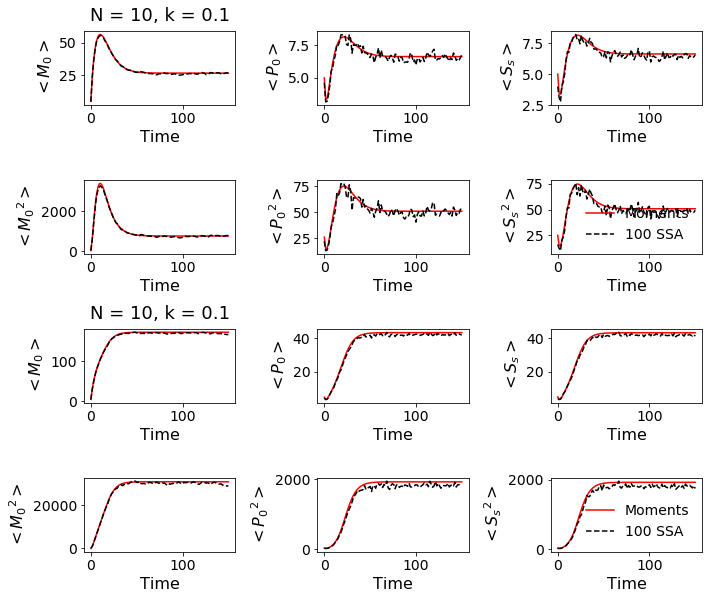

In [11]:
count = 0
plt.figure(figsize=(10,12))
N = 10
k = 0.8
for induce in [0.1,1]:
    sub_u = u_df[(u_df['N']==N) & (u_df['induce']==induce)]
    sub_s = s_df[(s_df['N']==N) & (s_df['k']==k) & (s_df['induce']==induce)]
    mean_s = sub_s.groupby('time').mean()
    var_s = (sub_s.groupby('time').std())**2+(sub_s.groupby('time').mean())**2
    plt.subplot(6,3,count+1)
    plt.plot(sub_u['Time'], sub_u['M0'], 'r')
    plt.plot(mean_s.index, mean_s['M0'], linestyle = '--', color = 'black')
    plt.title('N = '+str(N)+', k = 0.1')
    plt.ylabel('$<M_0>$')
    plt.xlabel('Time')
    plt.subplot(6,3,count+4)
    plt.plot(sub_u['Time'], sub_u['M0**2'], 'r')
    plt.plot(var_s.index, var_s['M0'], linestyle = '--', color = 'black')
    plt.ylabel('$<{M_0}^2>$')
    plt.xlabel('Time')
    plt.subplot(6,3,count+2)
    plt.plot(sub_u['Time'], sub_u['P0'], 'r', label = 'Moments')
    plt.plot(var_s.index, mean_s['P0'], linestyle = '--', color = 'black', label = '100 SSA')
    plt.ylabel('$<{P_0}>$')
    plt.xlabel('Time')
    plt.subplot(6,3,count+5)
    plt.plot(sub_u['Time'], sub_u['P0**2'], 'r', label = 'Moments')
    plt.plot(var_s.index, var_s['P0'], linestyle = '--', color = 'black', label = '100 SSA')
    plt.ylabel('$<{P_0}^2>$')
    plt.xlabel('Time')
    plt.subplot(6,3,count+3)
    plt.plot(sub_u['Time'], sub_u['Ss'], 'r')
    plt.plot(mean_s.index, mean_s['Ss'], linestyle = '--', color = 'black')
    plt.ylabel('$<S_s>$')
    plt.xlabel('Time')
    plt.subplot(6,3,count+6)
    plt.plot(sub_u['Time'], sub_u['Ss**2'], 'r', label = 'Moments')
    plt.plot(var_s.index, var_s['Ss'], linestyle = '--', color = 'black', label = '100 SSA')
    plt.ylabel('$<{S_s}^2>$')
    plt.xlabel('Time')
    count = count + 6
    plt.legend(loc = 4, frameon = False)
    plt.tight_layout()
plt.show()    

## Generate plot for paper
Plot the results from symmetry-reduced model and representative SSA traces.

/Users/gonzales/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/gonzales/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



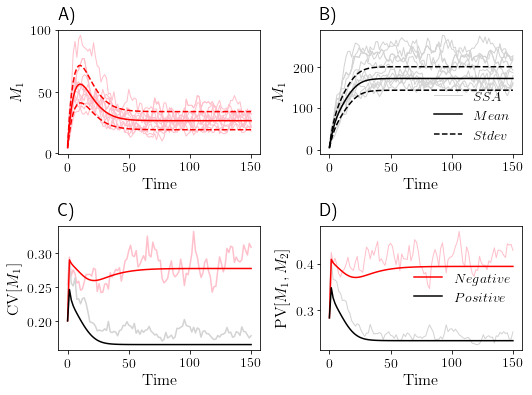

In [12]:
plt.figure(figsize=(7.5,5.6))
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')

plt.subplot(2,2,1)
bg_color = 'pink'
N = 10
k = 0.8
s = 'M0'   
sub_s = s_df[(s_df['N']==N) & (s_df['induce']==0.1) & (s_df['k']==k)]
for i in range(10):
    trace = sub_s[i*100:(i*100)+100]
    plt.plot(trace['time'], trace[s], linestyle = '-', color = bg_color, linewidth = 1, zorder = 0, label = '_nolegend_')
plt.plot(trace['time'], trace[s], linestyle = '-', color = bg_color, linewidth = 1, zorder = 0, label = '$SSA$')
sub_u = u_df[(u_df['N']==N) & (u_df['induce']==0.1)]
plt.plot(sub_u['Time'], sub_u[s], color = 'red', linestyle = '-', linewidth = 1.5, label = '$Mean$')
plt.plot(sub_u['Time'], sub_u[s]-sub_u['Std('+s+')'], linestyle = '--', color = 'red', linewidth = 1.5, label = '$Stdev$')
plt.plot(sub_u['Time'], sub_u[s]+sub_u['Std('+s+')'], linestyle = '--', color = 'red', linewidth = 1.5, label = '_nolegend_')
plt.xlabel('$\mathrm{Time}$')
plt.ylabel('$M_1$')
plt.title('A)', loc = 'left')
plt.subplot(2,2,2)
bg_color = 'lightgrey'
sub_s = s_df[(s_df['N']==N) & (s_df['induce']==1) & (s_df['k']==k)]
for i in range(10):
    trace = sub_s[i*100:(i*100)+100]
    plt.plot(trace['time'], trace[s], linestyle = '-', color = bg_color, linewidth = 1, zorder = 0, label = '_nolegend_')
plt.plot(trace['time'], trace[s], linestyle = '-', color = bg_color, linewidth = 1, zorder = 0, label = '$SSA$')
sub_u = u_df[(u_df['N']==N) & (u_df['induce']==1)]
plt.plot(sub_u['Time'], sub_u[s], color = 'black', linestyle = '-', linewidth = 1.5, label = '$Mean$')
plt.plot(sub_u['Time'], sub_u[s]-sub_u['Std('+s+')'], linestyle = '--', color = 'black', linewidth = 1.5, label = '$Stdev$')
plt.plot(sub_u['Time'], sub_u[s]+sub_u['Std('+s+')'], linestyle = '--', color = 'black', linewidth = 1.5, label = '_nolegend_')
plt.xlabel('$\mathrm{Time}$')
plt.ylabel('$M_1$')
plt.legend(frameon = False, loc = 4)
plt.title('B)', loc = 'left')

plt.subplot(2,2,3)
styles = ['-','--',':']
induce = 0.1
sub_u = u_df[(u_df['N']==10) & (u_df['induce']==induce)]
sub_s = s_df[(s_df['N']==10) & (s_df['induce']==induce)]
cv = sub_s.groupby('time').std()['M0']/sub_s.groupby('time').mean()['M0']
plt.plot(cv.index, cv, color = 'pink', zorder = 0, label = '_nolegend_')
plt.plot(sub_u['Time'], sub_u['CV(M0)'], color = 'red', linestyle = '-', label = '$Negative$')
induce = 1
sub_u = u_df[(u_df['N']==10) & (u_df['induce']==induce)]
sub_s = s_df[(s_df['N']==10) & (s_df['induce']==induce)]
cv = sub_s.groupby('time').std()['M0']/sub_s.groupby('time').mean()['M0']
plt.plot(cv.index, cv, color = 'lightgrey', zorder = 0, label = '_nolegend_')
plt.plot(sub_u['Time'], sub_u['CV(M0)'], color = 'black', linestyle = '-', label = '$Positive$')


plt.ylabel('$\mathrm{CV}[M_1]$')
plt.xlabel('$\mathrm{Time}$')
plt.title('C)', loc = 'left')


plt.subplot(2,2,4)
styles = ['-','--',':']
induce = 0.1
sub_u = u_df[(u_df['N']==10) & (u_df['induce']==induce)]
sub_s = s_df[(s_df['N']==10) & (s_df['induce']==induce)]
sub_s['(M0-M1)^2'] = (sub_s['M0']-sub_s['M1'])**2
s_var = (sub_s.groupby('time').mean()['(M0-M1)^2']/(sub_s.groupby('time').mean()['M0']*sub_s.groupby('time').mean()['M1']))**0.5
plt.plot(s_var.index, s_var, zorder = 0, color = 'pink', label = '_nolegend_', linewidth = 1)
plt.plot(sub_u['Time'], (sub_u['Var(M0-M1)']/(sub_u['M0']**2))**0.5, color = 'red', linestyle = '-', label = '$Negative$')
induce = 1
sub_u = u_df[(u_df['N']==10) & (u_df['induce']==induce)]
sub_s = s_df[(s_df['N']==10) & (s_df['induce']==induce)]
sub_u = u_df[(u_df['N']==10) & (u_df['induce']==induce)]
sub_s = s_df[(s_df['N']==10) & (s_df['induce']==induce)]
sub_s['(M0-M1)^2'] = (sub_s['M0']-sub_s['M1'])**2
s_var = (sub_s.groupby('time').mean()['(M0-M1)^2']/(sub_s.groupby('time').mean()['M0']*sub_s.groupby('time').mean()['M1']))**0.5
plt.plot(s_var.index, s_var, zorder = 0, color = 'lightgrey', label = '_nolegend_', linewidth = 1)
plt.plot(sub_u['Time'], (sub_u['Var(M0-M1)']/(sub_u['M0']**2))**0.5, color = 'black', linestyle = '-', label = '$Positive$')
plt.ylabel('$\mathrm{PV}[M_1,M_2]$')
plt.xlabel('$\mathrm{Time}$')
plt.title('D)', loc = 'left')
plt.legend(frameon = False, loc = 5)
plt.tight_layout()

plt.savefig('genefeedback.eps', pad_inches=0)
plt.show()